# Stacked Models - 01 - Setup & Cleaning

## Imports and Setup.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
# plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "okcupid-stem"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

SEED = 42
DEBUG = True

In [2]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Datasets

In [4]:
from openml.datasets import get_dataset

did = 41440

dataset = get_dataset(did)

print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)

This is dataset 'okcupid-stem', the target feature is 'job'


## Target

In [5]:
target = dataset.default_target_attribute
df, _, categorical_indicator, attribute_names = dataset.get_data(dataset_format="dataframe")

In [6]:
print(df.shape)
df.head(5)

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,NaN,non_stem,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,non_stem,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
3,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,NaN,non_stem,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single
4,29,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,NaN,stem,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single


## Clean and EDA

* Target has three levels `non_stem`, `stem`, and `student`. 
  * Will drop students so will have a binary classification problem.
* Categorical features are of category type
  * Need to update categories when cleaning/feature engineering.
* Many features have large number of missing values:
  * For categorical features we will create a new category "NaN".
* Many categorical features have large number of levels and/or have rare levels.
  * Bin to improve quality of features.

In [7]:
# drop rows with target=='student'
df = df.loc[df[target]!="student"].copy()
# reset category levels in target
df[target] = pd.Categorical(df[target], df[target].unique().tolist() )

In [8]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

## Features

Since the main purpose of this practical was building stacked models I'm only going to pick a subset of the features, namely:

* Categorical: ``body_type``, ``diet``, ``drinks``, ``drugs``, ``orientation``, ``pets``, ``religion``, ``sex``, ``smokes``, ``status``.
* Numerical: ``age``, ``height``.

In [9]:
cat_features = set()
num_features = set()

### `body_type`

### Original `body_type` values

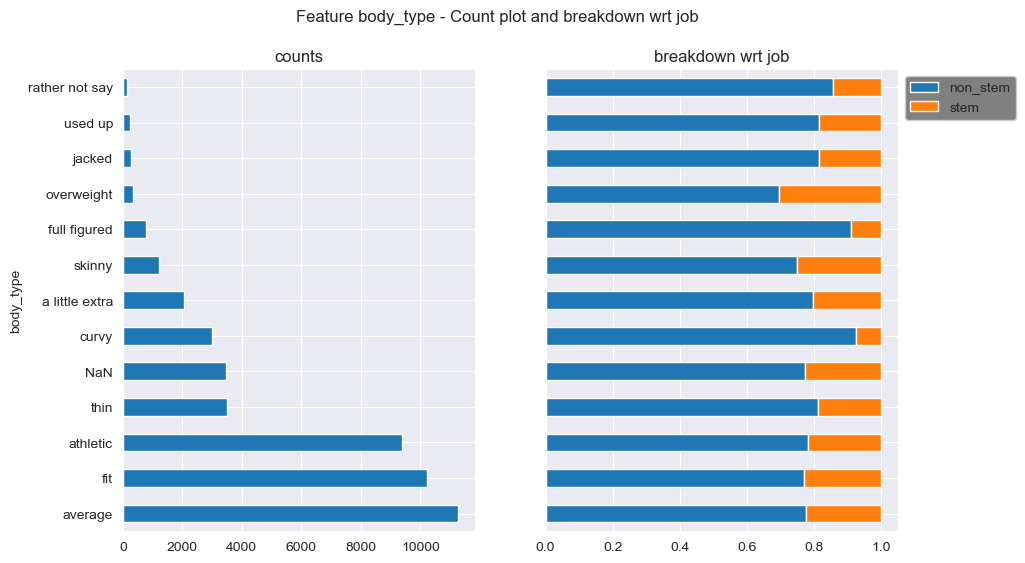

In [10]:
feature = "body_type"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

This shows I have to merge some levels:
* Merge rare level "rather not say" and "used up" with "NaN".
* Merge rare level "a little extra" with "overweight".
* Merge rare level "jacked" with "fit".
* Merge rare level "full figured" with "curvy" - here I'm assuming "curvy" does not mean a "dad bod".

### Processed `body_type` values

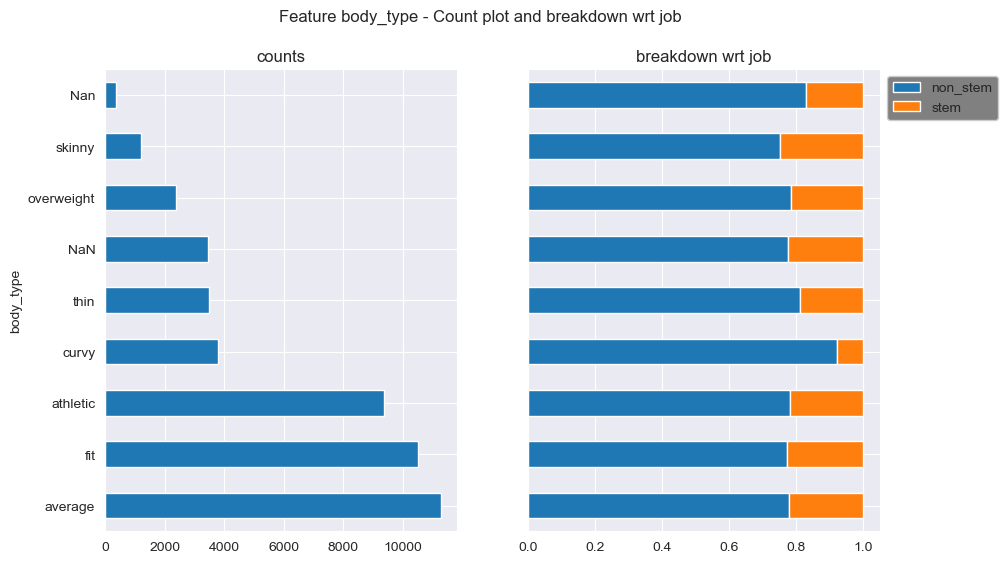

In [11]:
replace_map = {
    "rather not say": "Nan",
    "used up": "Nan",
    "a little extra": "overweight",
    "jacked": "fit",
    "full figured": "curvy",
}

df[feature] = df[feature].replace(replace_map)

display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)

### `diet`

### Original `diet` values

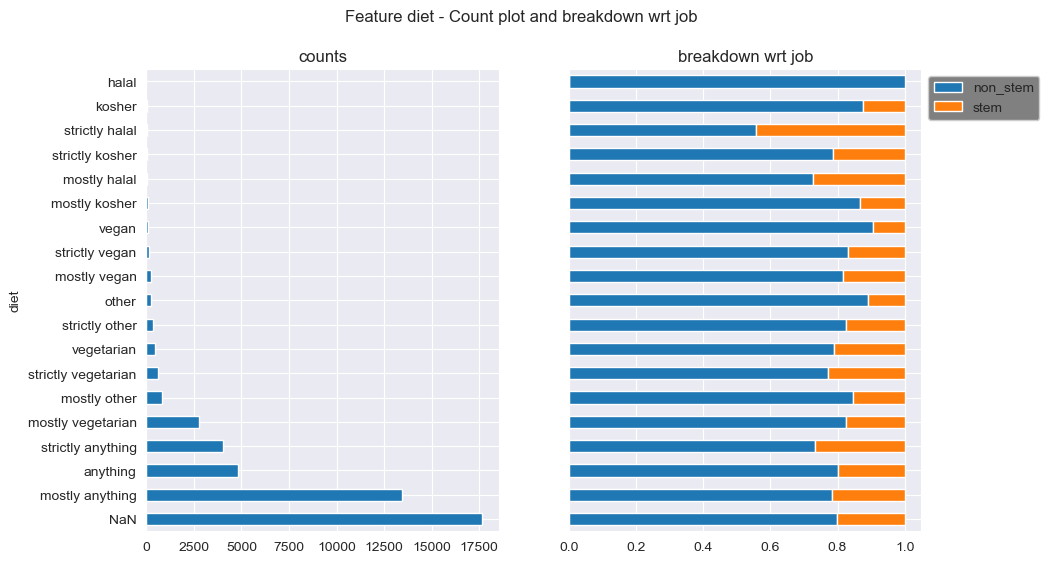

In [12]:
feature = "diet"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

This shows:
* Merge "strictly vegetarian" with "vegetarian".

In [13]:
df[feature] = df[feature].replace({
    "strictly vegetarian": "vegetarian",
})

* Treat all levels with frequency less that that of "strictly other" as rare and merge with "mostly other".

In [14]:
val_counts = df[feature].value_counts()
num_occur_for_strictly_other = val_counts["strictly other"]
categories_less_than_strictly_other = val_counts[val_counts < num_occur_for_strictly_other].index
for cat in categories_less_than_strictly_other:
    df[feature] = df[feature].replace(cat, "strictly other")

### Processed `diet` values

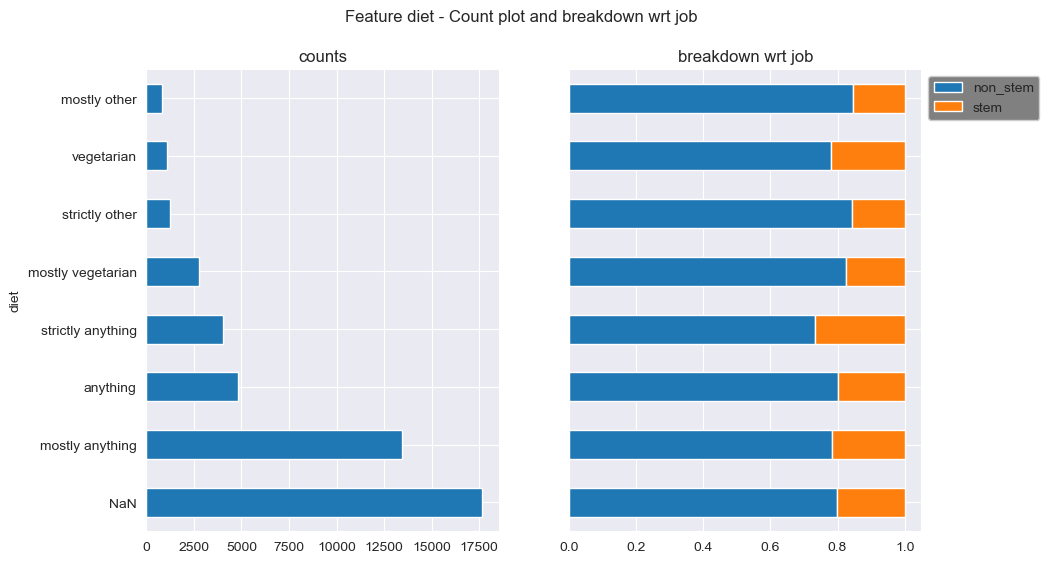

In [15]:
display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)

### `drinks`

### Original `drinks` values

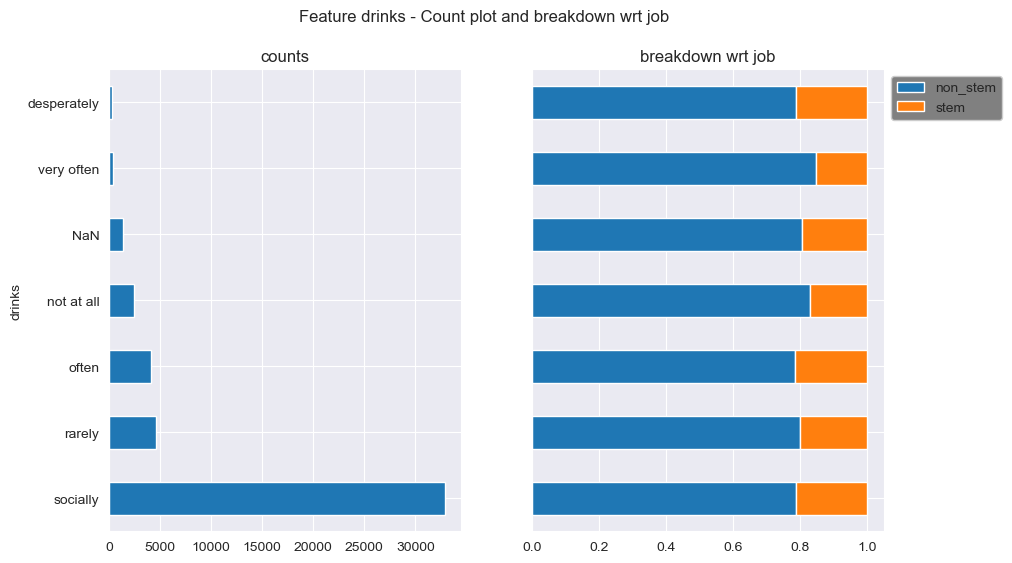

In [16]:
feature = "drinks"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``drugs``

### Original `drugs` values

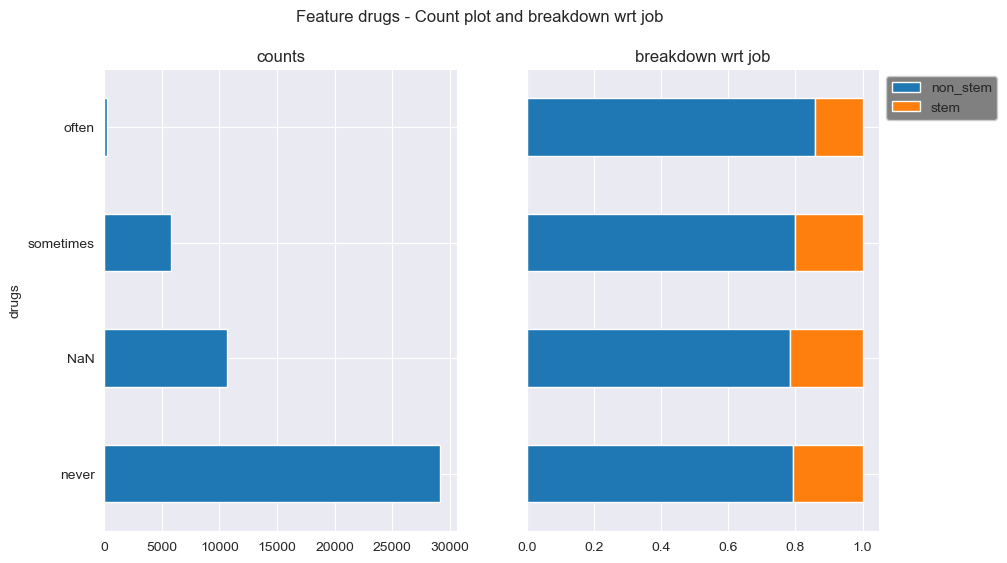

In [17]:
feature = "drugs"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``orientation``

### Original `education` values

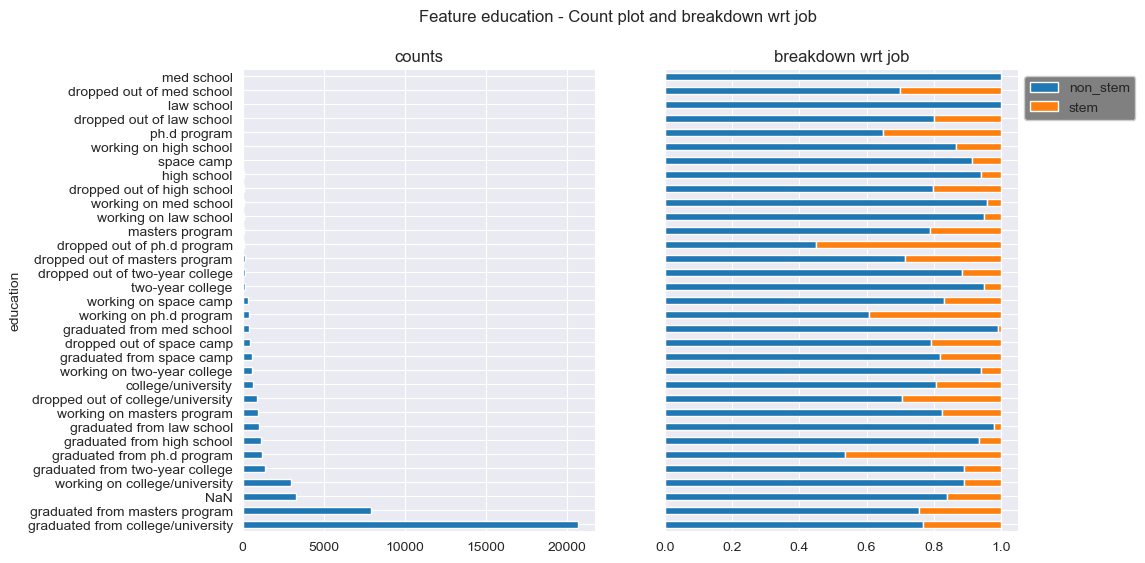

In [18]:
feature = "education"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``pets``

### Original `pets` values

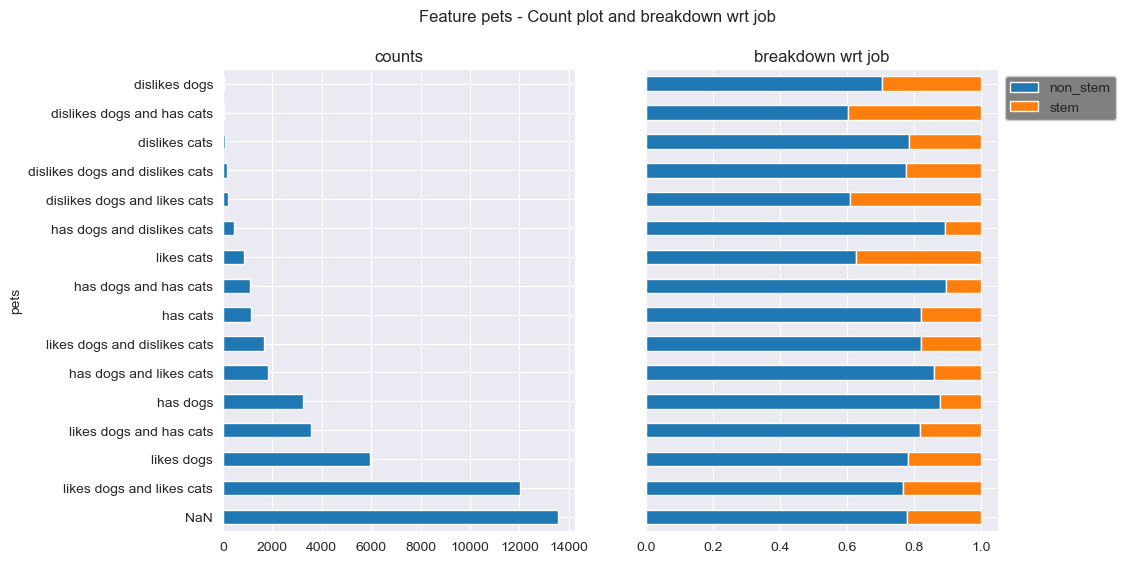

In [19]:
feature = "pets"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``sex``

### Original `religion` values

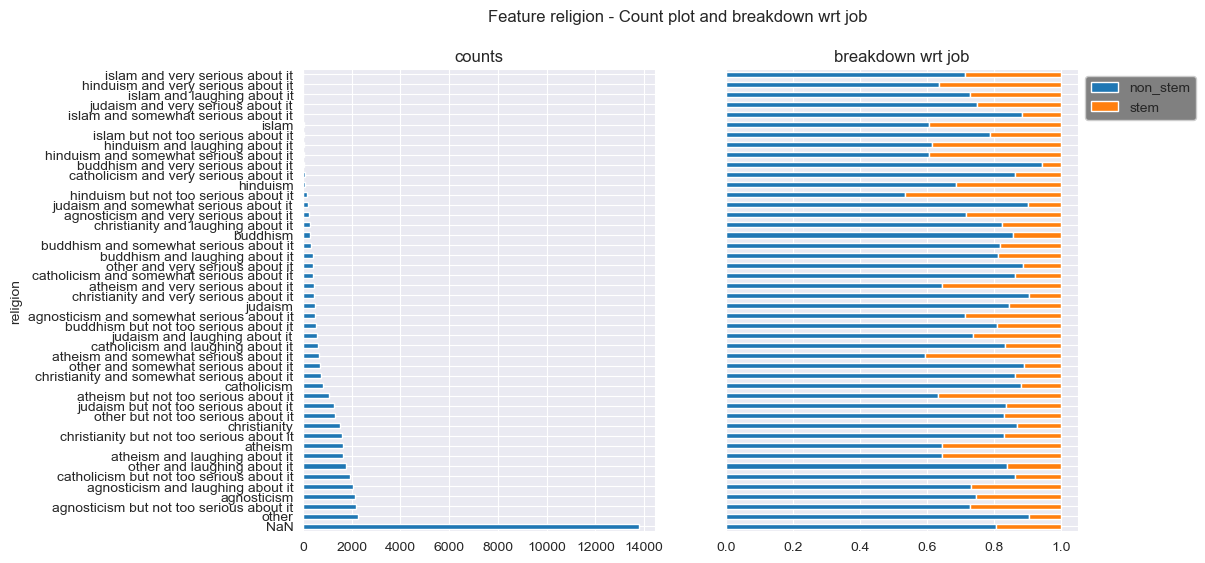

In [20]:
feature = "religion"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``smokes``

### Original `smokes` values

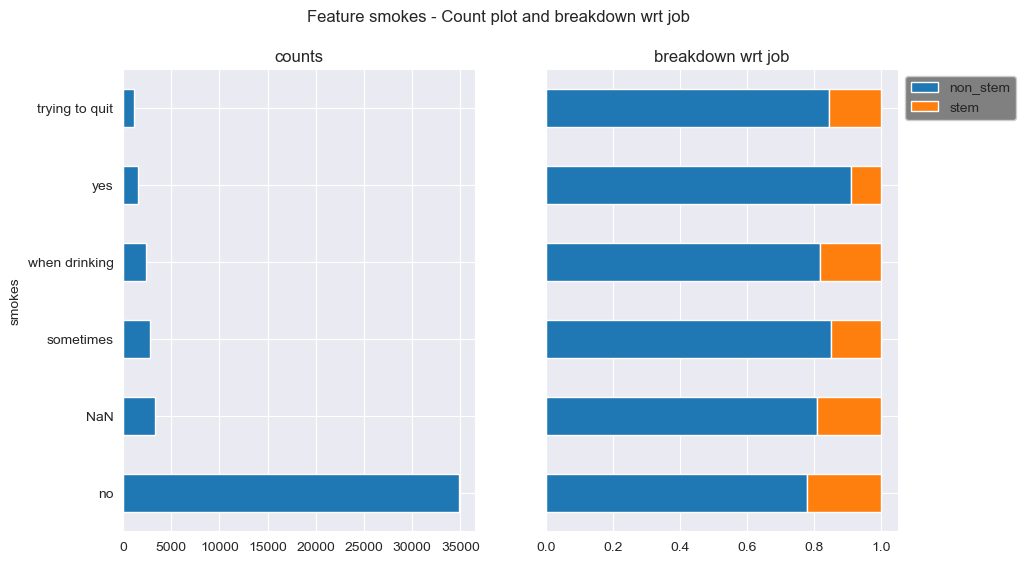

In [21]:
feature = "smokes"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### `religion`

### Original `religion` values

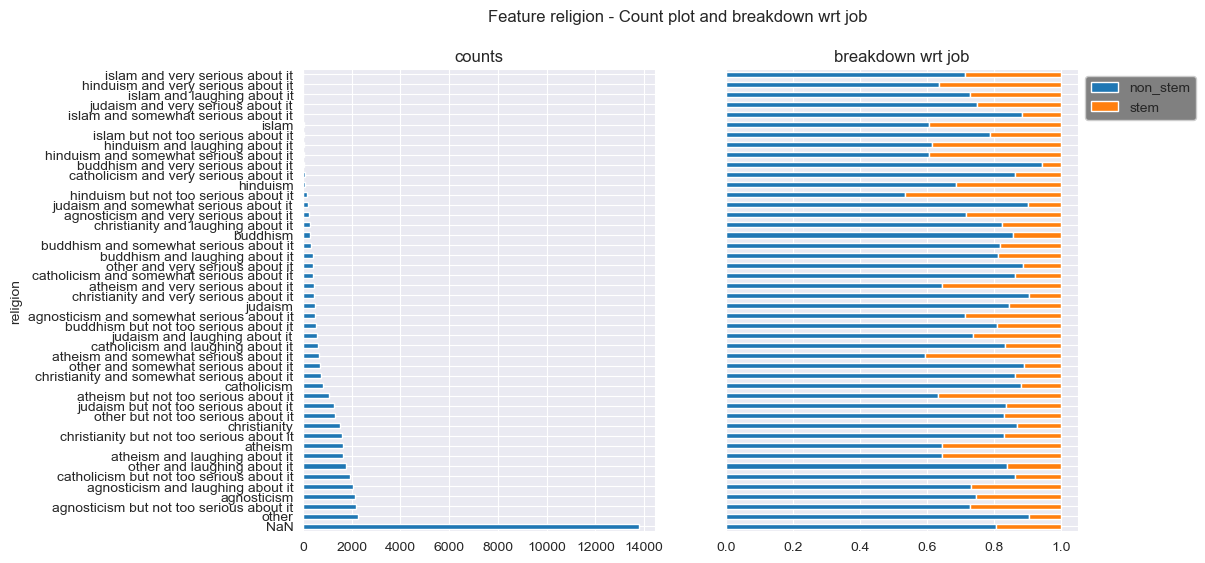

In [22]:
feature = "religion"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

* Merge the religions without levels

In [23]:
levels = df[feature].unique().tolist()
religions = [r for r in levels if len(r.split())==1]

for religion in religions:
    criteria = df[feature].str.contains(religion)
    df.loc[criteria, feature] = religion

### Processed `religion` values

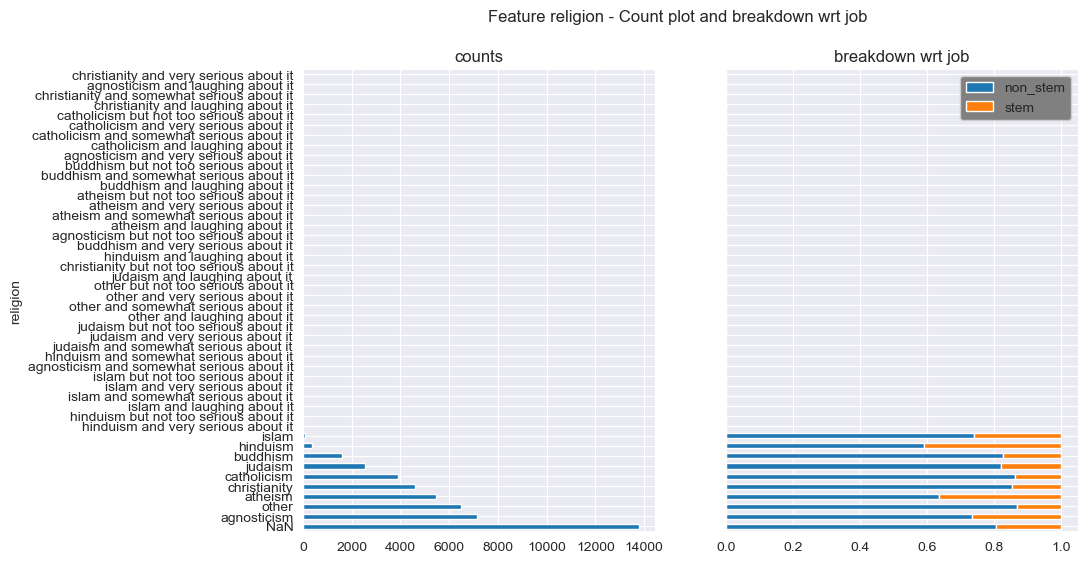

In [24]:
display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)


### ``status``

### Original `status` values

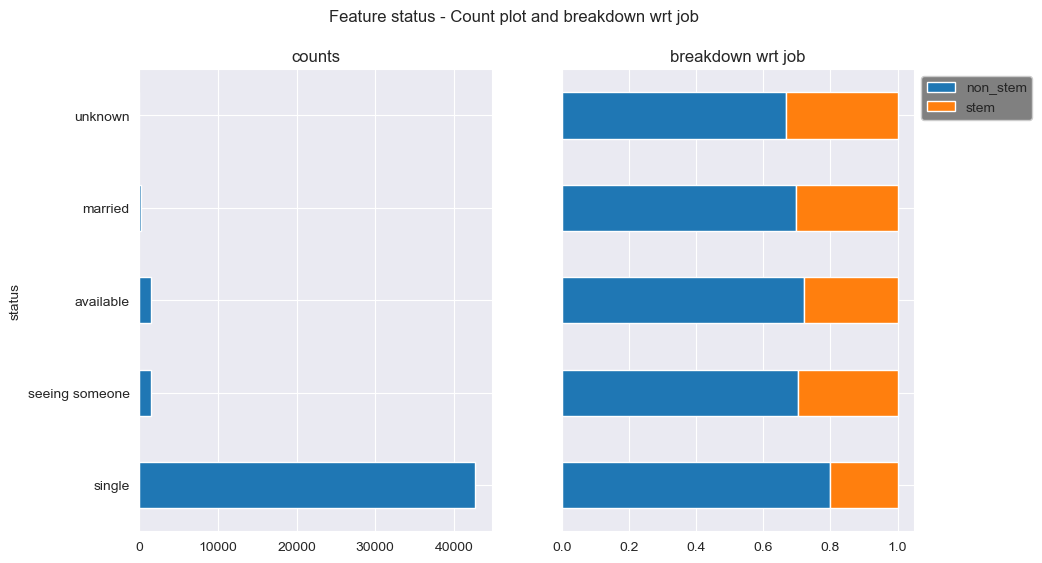

In [25]:
feature = "status"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}


### ``age``

In [26]:
feature = "age"

num_features |= {feature}

### ``height``

In [27]:
feature = "height"

num_features |= {feature}

* Drop the rows with missing values

In [28]:
df = df.loc[df[feature].notna()].copy()

## Preprocessing

In [29]:
cat_features = list(cat_features)
num_features = list(num_features)
features = cat_features + num_features
print(f"cat_features: {cat_features}")
print(f"num_features: {num_features}")

cat_features: ['status', 'smokes', 'drugs', 'religion', 'education', 'pets', 'drinks', 'body_type', 'diet']
num_features: ['age', 'height']


In [30]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.6, stratify=df[target], random_state=SEED)
df_train.shape, df_test.shape

((27543, 11), (18363, 11))

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_e = OneHotEncoder()
num_e = StandardScaler()

data = cat_e.fit_transform(df_train[cat_features]).toarray()
index = df_train.index
columns = cat_e.get_feature_names_out()
df_cat = pd.DataFrame(data=data, index=index, columns=columns)

data = num_e.fit_transform(df_train[num_features])
index = df_train.index
columns = num_features
df_num = pd.DataFrame(data=data, index=index, columns=num_features)

df_train = pd.concat([df_cat, df_num], axis=1)

display(df_train.head(1))

y_train = y_train.map( {'non_stem':0, "stem":1} )

,status_available,status_married,status_seeing someone,status_single,status_unknown,smokes_NaN,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes,drugs_NaN,drugs_never,drugs_often,drugs_sometimes,religion_NaN,religion_agnosticism,religion_atheism,religion_buddhism,religion_catholicism,religion_christianity,religion_hinduism,religion_islam,religion_judaism,religion_other,education_NaN,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,pets_NaN,pets_dislikes cats,pets_dislikes dogs,pets_dislikes dogs and dislikes cats,pets_dislikes dogs and has cats,pets_dislikes dogs and likes cats,pets_has cats,pets_has dogs,pets_has dogs and dislikes cats,pets_has dogs and has cats,pets_has dogs and likes cats,pets_likes cats,pets_likes dogs,pets_likes dogs and dislikes cats,pets_likes dogs and has cats,pets_likes dogs and likes cats,drinks_NaN,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,body_type_NaN,body_type_Nan,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_overweight,body_type_skinny,body_type_thin,diet_NaN,diet_anything,diet_mostly anything,diet_mostly other,diet_mostly vegetarian,diet_strictly anything,diet_strictly other,diet_vegetarian,age,height
42096,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.563824,0.668087


## Base Learners / Estimators

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
models = {
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(),
    #"KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
    "ET": ExtraTreesClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
}

: 

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

: 

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for name,model in models.items():
    scores = cross_val_score(model, df_train, y_train, cv=cv)
    print(name, scores.mean())

: 

## Stacked Learners

Notes:
Takes the probabilities of a set of base learners and creates a mixed model to make the final prediction.


In [ ]:
from sklearn.ensemble import StackingClassifier

: 

``level_1_model`` - Combines the models using "LR" or Logistic Regression.

In [ ]:
level_0_models = models
level_1_model = models['LR']

: 

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

stacking_model = StackingClassifier(
    estimators=list(level_0_models.items()), final_estimator=level_1_model, 
    passthrough=True, cv=cv, stack_method="predict_proba")

: 

In [ ]:
tmp = stacking_model.fit_transform(df_train, y_train)

: 

In [ ]:
level_0_columns = [f"{name}_prediction" for name in models.keys()]

df_stacked = pd.DataFrame(tmp, columns=level_0_columns+list(df_train.columns))
df_stacked.head()

: 

In [ ]:
scores = cross_val_score(stacking_model, df_train, y_train, cv=10)
scores.mean(), scores.std()

: 

In [ ]:
y_pred = stacking_model.predict(df_test)
y_true = y_test

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))

: 